<a href="https://colab.research.google.com/github/ananyas168/LIDAR_3D_Cloud_point/blob/main/Pointnet/PointNetSegmentation_from_scratch_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# This is an implementation of PointNet using pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
#loading dataset
data = pd.read_csv('/content/drive/MyDrive/combined.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,1,2,3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
data.shape

(36308022, 5)

In [ ]:
#cleaning the dataset
data_clean = data[data['//X'].str.contains("//X") == False]
data_clean.shape

(3407657, 5)

In [ ]:
# print(len(data))
data_clean.dropna(inplace=True)
data_clean.shape

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(3407441, 5)

In [ ]:
#spliting the dataset
train_data, test_data = train_test_split(data_clean, test_size=0.2)

In [ ]:
type(train_data)

pandas.core.frame.DataFrame

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Tnet 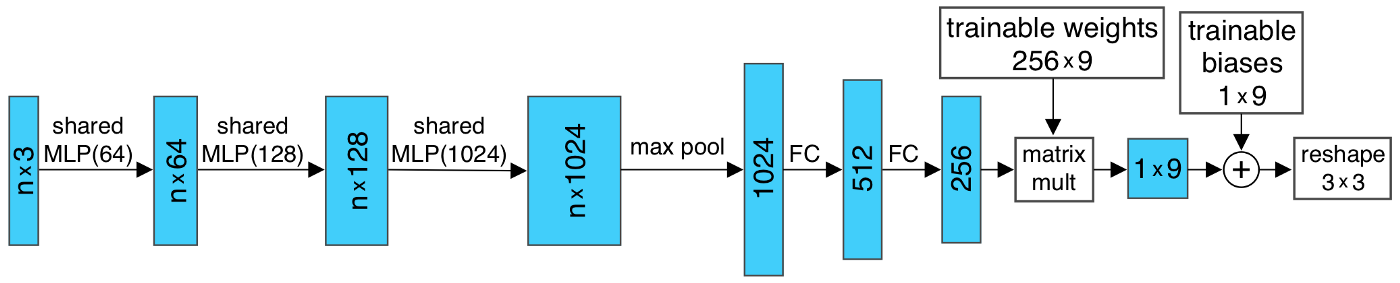

In [ ]:
# Define the T-net 

class Tnet(nn.Module):
    '''
     Parameters:
                Input: x which has shape n X k Matrix, where n is the no of data points(i.e no of rows in te dataframe)
                Output: 3 x3 matrix
    '''
    def __init__(self,k=3):
        super().__init__()
        self.k = k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self,x):
        bs = x.size(0)
        # print(x)
        x = torch.reshape(x,(x.shape[0],x.shape[1],1))
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = nn.MaxPool1d(x.size(-1))(x)
        x = nn.Flatten(1)(x)
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))

        init = torch.eye(self.k,requires_grad=True).repeat(bs,1,1)
        if x.is_cuda:
            init = init.cuda()
        matrix = self.fc3(x).view(-1,self.k,self.k) + init
        return matrix


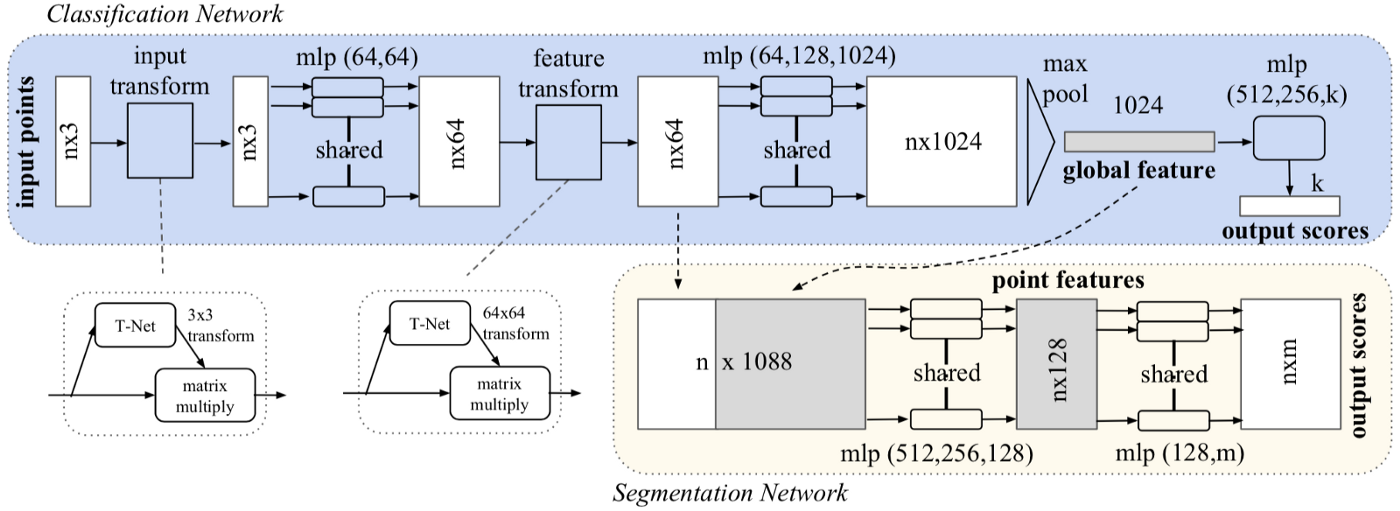

In [ ]:
class Transform(nn.Module):
    '''
     Parameters:
                Input: 
                      x= input data of shape n X k Matrix, where n is the no of data points(i.e no of rows in te dataframe)
                Output: 
                      x  = flatten output of shape(n x 1024)
                      x_out = intermediate outpu of shape (n x 64) 
                      matrix3 = Tnet output shape(k x k)
                      matrix64 = Tnet output shape(64 x 64)
    '''               
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=4)
        self.feature_transform = Tnet(k=64)

        self.conv1 = nn.Conv1d(4,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self,x):
        matrix3 = self.input_transform(x)
        # x = torch.bmm(torch.transpose(x,1,2),matrix3).transpose(1,2)
        # print(x)
        x = torch.reshape(x,(x.shape[0],x.shape[1],1))
        # print(x.shape)
        # print(matrix3.shape)
        x = torch.bmm(torch.transpose(x,1,2),matrix3).transpose(1,2)
        x = F.relu(self.bn1(self.conv1(x)))

        matrix64 = self.feature_transform(x)
        # x_out = torch.bmm(torch.transpose(x,1,2),matrix64).transpose(1,2)
        x_out = torch.bmm(torch.transpose(x,1,2),matrix64).transpose(1,2)
        x = F.relu(self.bn2(self.conv2(x_out)))
        x= self.bn3(self.conv3(x))
        x = nn.MaxPool1d(x.size(-1))(x)
        x = nn.Flatten(1)(x)
        return x, x_out, matrix3, matrix64

In [ ]:
class PointNet(nn.Module):
     '''
     Parameters:
                Input: 
                      x= input data of shape n X k Matrix, where n is the no of data points(i.e no of rows in te dataframe)
                Output: 
                      x  = flatten output of shape(n x classes)
                      matrix3 = Tnet output shape(k x k)
                      matrix64 = Tnet output shape(64 x 64)
    '''   
    def __init__(self,classes=10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,classes)

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self,x):
        x , matrix3, matrix64 = self.transform(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        x = self.logsoftmax(x)

        return x, matrix3, matrix64

In [ ]:
class PointNetSeg(nn.Module):
    
     '''
     Parameters:
                Input: 
                      x= input data of shape n X k Matrix, where n is the no of data points(i.e no of rows in te dataframe)
                Output: 
                      x  = flatten output of shape(n x classes)
                      matrix3 = Tnet output shape(k x k)
                      matrix64 = Tnet output shape(64 x 64)
    '''   
    def __init__(self,classes):
        super().__init__()
        self.transform = Transform()


        self.fc1 = nn.Conv1d(1088,512,1)
        self.fc2 = nn.Conv1d(512,256,1)
        self.fc3 = nn.Conv1d(256,128,1)
        self.fc4 = nn.Conv1d(128,classes,1)

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        # self.dropout = nn.Dropout(p=0.3)
        # self.logsoftmax = nn.LogSoftmax(dim=2)
        self.logsoftmax = nn.Softmax(dim=1)

    def forward(self,x):
        x , x_out, matrix3, matrix64 = self.transform(x)
        # print(x_out.shape)
        # print(x_out)
        # print(x.shape)
        # print(x)
        x = x.reshape(x.shape[0],1,x.shape[1])
        x = x.repeat(1,x_out.shape[2],1)
        # print(x.shape)
        # print(x)
        
        # print(x_out.transpose(1,2).shape)
        # print(x_out.shape)
        x = torch.cat((x_out,x.transpose(1,2)),1)

        # print(x.shape)
        # x = self.fc1(x)
        # x = self.bn1(x)
        # x = F.relu(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        # x = F.relu(self.bn3(self.dropout(self.fc3(x))))
        x = self.fc4(x)
        x = self.logsoftmax(x)

        return x, matrix3, matrix64

In [ ]:
def pointnet_loss(outputs,labels,m3,m64,alpha=0.00001):
     
     '''
     Parameters:
                Input: 
                     outputs: model predictions of shape (n x 1) 
                     labels: truth labels corresponding to the data fed = shape (n x 1)
                     m3 : output of (k x k ) from poinet model, heer k = 4
                     m64 : output of (64 x 64 ) from poinet model
                Output: 
                     loss: loss over the predicted data
    '''   
    criterion = nn.NLLLoss()
    bs = outputs.size(0)
    id3 = torch.eye(4,requires_grad=True).repeat(bs,1,1)
    id64 = torch.eye(64,requires_grad=True).repeat(bs,1,1)

    if outputs.is_cuda:
        id3 = id3.cuda()
        id64 = id64.cuda()
    diff3 = id3 - torch.bmm(m3,m3.transpose(1,2))
    diff64 = id64 - torch.bmm(m64,m64.transpose(1,2))
    return criterion(outputs,labels) + alpha * (torch.norm(diff3) + torch.norm(diff64))/float(bs)

In [ ]:
pointnet = PointNetSeg(2).to(device).float() # classes = 2

In [ ]:
def train(model,train_data,test_data,epochs=10):
    for epoch in range(epochs):
        x_train = torch.tensor(train_data.iloc[:,:-1].values.astype('float32')).to(device)
        y_train = torch.tensor(train_data.iloc[:,-1:].values.astype('int32')).type(torch.LongTensor).to(device)
        
        pred,mat3,mat64 = model(x_train.float())
        train_loss = pointnet_loss(pred,y_train,mat3,mat64)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        x_test = torch.tensor(test_data.iloc[:,:-1].values.astype('float32')).to(device)
        y_test = torch.tensor(test_data.iloc[:,-1:].values.astype('int32')).type(torch.LongTensor).to(device)

        correct = 0
        with torch.no_grad():
            pred, mat3, mat64 = model(x_test.float())
            pred_label = torch.argmax(pred, dim=1)
            correct += (pred_label==y_test).sum().cpu().numpy()
            
            test_loss = pointnet_loss(pred,y_test,mat3,mat64)
  
        print(f'Epoch:{epoch} Train Loss:{round(train_loss.item(),5)} Test_loss:{round(test_loss.item(),5)}')
        print(f'Accuracy: {round(correct/len(y_test),5)*100}')
        

In [ ]:
optimizer = torch.optim.Adam(pointnet.parameters(),lr=0.0001)

In [ ]:
print(len(train_data))
print(len(test_data))

2725952
681489


In [ ]:
train_small = train_data.iloc[:20000,:]
test_small = test_data.iloc[:2000,:]

train(pointnet,train_small,test_small,epochs=10)

Epoch:0 Train Loss:-0.966 Test_loss:-0.96273
Accuracy: 97.7
Epoch:1 Train Loss:-0.96674 Test_loss:-0.96402
Accuracy: 97.85000000000001
Epoch:2 Train Loss:-0.96729 Test_loss:-0.96538
Accuracy: 98.0
Epoch:3 Train Loss:-0.96779 Test_loss:-0.96667
Accuracy: 98.1
Epoch:4 Train Loss:-0.96839 Test_loss:-0.96698
Accuracy: 98.05
Epoch:5 Train Loss:-0.96887 Test_loss:-0.96694
Accuracy: 98.05
Epoch:6 Train Loss:-0.96934 Test_loss:-0.96667
Accuracy: 97.89999999999999
Epoch:7 Train Loss:-0.96964 Test_loss:-0.96625
Accuracy: 97.85000000000001
Epoch:8 Train Loss:-0.97002 Test_loss:-0.96647
Accuracy: 97.89999999999999
Epoch:9 Train Loss:-0.97042 Test_loss:-0.96722
Accuracy: 97.95
